In [1]:
from fastai import *
from fastai.tabular.all import *
from fastai.vision.all import *
from utils import *

from fastai.imports import *
from fastai.vision.widgets import *
pd.options.display.max_rows = 20
pd.options.display.max_columns = None
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sb


In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import fastbook
fastbook.setup_book()
from fastbook import *

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG


from dtreeviz.trees import *

In [4]:
path = Path()
path.ls()

(#12) [Path('.ipynb_checkpoints'),Path('models'),Path('houseP4rices.html'),Path('housePrice.html'),Path('housePrice.ipynb'),Path('submission1_nar_housePrice.csv'),Path('submission3_nar_housePrice.csv'),Path('test.csv'),Path('train.csv'),Path('submission4_nar_housePrice.csv')...]

In [5]:
# Lets try with a NN 

In [6]:
dep_var = 'SalePrice'

In [7]:
df_nn = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')
df_nn[dep_var] = np.log(df_nn[dep_var])

In [8]:
cont_nn,cat_nn = cont_cat_split(df_nn, dep_var=dep_var)
splits = RandomSplitter(valid_pct=0.2)(range_of(df_nn))

In [9]:
cont_nn

['Id',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'MiscVal']

In [10]:
cat_nn

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [11]:
for t in df_nn[cat_nn].nunique():
    print (t)

15
5
2
2
4
4
2
5
3
25
9
8
5
8
10
9
6
8
15
16
4
4
5
6
4
4
4
6
6
6
5
2
5
4
3
4
3
8
4
4
12
7
4
5
6
3
5
5
5
3
20
8
3
4
4
12
5
9
6


In [12]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [13]:
dls = to_nn.dataloaders(1024)

In [14]:
y = to_nn.train.y
y.min(),y.max()

(10.460242, 13.534473)

In [15]:
learn = tabular_learner(dls, y_range=(10.460242,13.534473),
                        n_out=1, metrics=rmse)

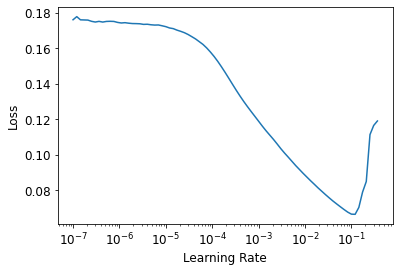

In [16]:
lr_min, lr_steep = learn.lr_find()

In [17]:
learn.fit_one_cycle(20,lr_steep)

epoch,train_loss,valid_loss,_rmse,time
0,0.171518,0.154894,0.393566,00:00
1,0.172694,0.154263,0.392764,00:00
2,0.170964,0.153266,0.391493,00:00
3,0.165538,0.151838,0.389664,00:00
4,0.158578,0.149931,0.387210,00:00
5,0.150301,0.147689,0.384304,00:00
6,0.141104,0.145267,0.381140,00:00
7,0.131553,0.142641,0.377679,00:00
8,0.122714,0.140100,0.374299,00:00
9,0.114664,0.137640,0.370999,00:00


epoch,train_loss,valid_loss,_rmse,time
0,0.030784,0.122427,0.349895,00:00
1,0.029890,0.121709,0.348868,00:00
2,0.029583,0.121305,0.348289,00:00
3,0.028837,0.121012,0.347868,00:00
4,0.028102,0.120593,0.347265,00:00
5,0.027197,0.119590,0.345817,00:00
6,0.026263,0.117493,0.342772,00:00
7,0.025136,0.114291,0.338069,00:00
8,0.023971,0.110218,0.331991,00:00
9,0.022668,0.106344,0.326105,00:00


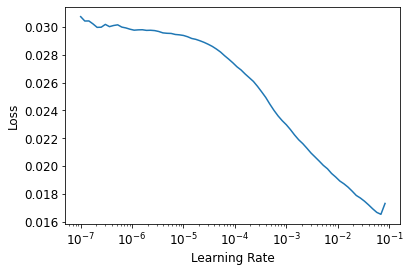

In [18]:
learn.unfreeze()
lrmin, lrsteep = learn.lr_find()
learn.fit_one_cycle(40,lrsteep)

epoch,train_loss,valid_loss,_rmse,time
0,0.001118,0.065242,0.255425,00:00
1,0.001085,0.064181,0.253339,00:00
2,0.001079,0.062772,0.250544,00:00
3,0.001062,0.061540,0.248073,00:00
4,0.001044,0.060437,0.245840,00:00
5,0.001027,0.057976,0.240782,00:00
6,0.001012,0.058000,0.240832,00:00
7,0.000980,0.055719,0.236049,00:00
8,0.000944,0.053877,0.232114,00:00
9,0.000901,0.052539,0.229213,00:00


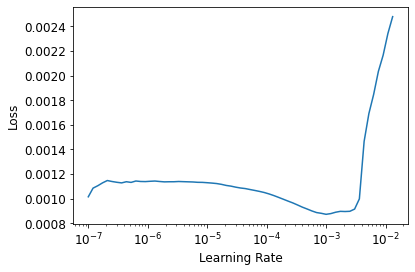

In [19]:
learn.unfreeze()
lrmin, lrsteep = learn.lr_find()
learn.fit_one_cycle(40,lrsteep)

In [20]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [21]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.153738

In [22]:
# Fill missing value in the test dataset first
df_test.fillna(value=df_test.mean(), inplace=True)

In [23]:
test_dl = dls.test_dl(df_test)

In [24]:
class_score, y = learn.get_preds(dl=test_dl)
class_score

tensor([[11.7124],
        [12.3377],
        [12.1249],
        ...,
        [11.9574],
        [11.6555],
        [12.3342]])

In [25]:
tmp = np.exp(class_score)
tmp = tmp.numpy()
tmp = tmp.astype(int)
labels = tmp.reshape(len(tmp,))
labels
# tmp = class_score.numpy()
# tmp2 = tmp.astype(int)
# labels = tmp2.reshape(418,)
# labels
# tmp2

array([122071, 228134, 184415, ..., 155964, 115318, 227333])

In [26]:
output= pd.DataFrame({'Id':df_test.Id, 'SalePrice': labels})
# output.to_csv('submission2_nar_housePrice.csv', index=False)
output.head()

# score  0.16379,  on kaggle board

,Id,SalePrice
0,1461,122071
1,1462,228134
2,1463,184415
3,1464,197061
4,1465,197887


In [27]:
# lets try with the best columns that we use for the random forest

In [28]:
col = ['OverallQual',
 'GrLivArea',
 'YearBuilt',
 'GarageArea',
 'TotalBsmtSF',
 'GarageCars',
 '1stFlrSF',
 'ExterQual',
 '2ndFlrSF',
 'BsmtFinSF1',
 'FireplaceQu',
 'LotArea',
 'YearRemodAdd',
 'KitchenQual',
 'OverallCond',
 'CentralAir']

In [29]:
df_nn_final = df_nn[col + [dep_var]]
splits = RandomSplitter(valid_pct=0.2)(range_of(df_nn_final))

In [30]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, dep_var=dep_var)

In [31]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [32]:
dls = to_nn.dataloaders(1024)

In [33]:
y = to_nn.train.y
y.min(),y.max()

(10.47195, 13.534473)

In [34]:
learn = tabular_learner(dls, y_range=(10.460242,13.534473),
                        n_out=1, metrics=rmse)

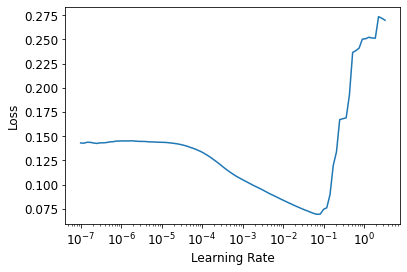

In [35]:
lr_min, lr_steep = learn.lr_find()

In [36]:
learn.fit_one_cycle(20,lr_steep)

epoch,train_loss,valid_loss,_rmse,time
0,0.145471,0.132433,0.363914,00:00
1,0.146100,0.131637,0.362819,00:00
2,0.143478,0.129977,0.360523,00:00
3,0.141004,0.127357,0.356871,00:00
4,0.135118,0.123794,0.351844,00:00
5,0.128064,0.119619,0.345860,00:00
6,0.120179,0.115142,0.339326,00:00
7,0.112555,0.110556,0.332500,00:00
8,0.105752,0.105966,0.325524,00:00
9,0.099425,0.101625,0.318787,00:00


epoch,train_loss,valid_loss,_rmse,time
0,0.035206,0.074540,0.273020,00:00
1,0.034585,0.073403,0.270931,00:00
2,0.034466,0.072467,0.269196,00:00
3,0.033908,0.071766,0.267891,00:00
4,0.033548,0.071050,0.266552,00:00
5,0.032729,0.069935,0.264452,00:00
6,0.032227,0.067899,0.260574,00:00
7,0.031630,0.064681,0.254325,00:00
8,0.030851,0.060740,0.246455,00:00
9,0.029926,0.056689,0.238095,00:00


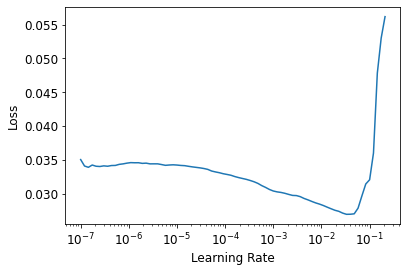

In [37]:
learn.unfreeze()
lrmin, lrsteep = learn.lr_find()
learn.fit_one_cycle(40,lrsteep)

epoch,train_loss,valid_loss,_rmse,time
0,0.012037,0.041123,0.202787,00:00
1,0.011945,0.039890,0.199726,00:00
2,0.012013,0.039312,0.198274,00:00
3,0.011994,0.039889,0.199722,00:00
4,0.011744,0.040369,0.200920,00:00
5,0.011510,0.041359,0.203369,00:00
6,0.011421,0.037099,0.192612,00:00
7,0.011301,0.043949,0.209640,00:00
8,0.011431,0.034476,0.185677,00:00
9,0.011418,0.038063,0.195097,00:00


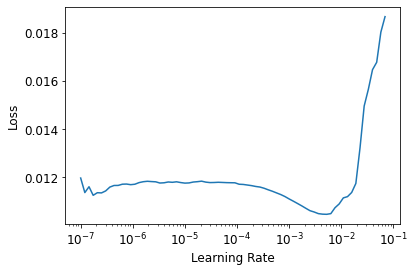

In [38]:
learn.unfreeze()
lrmin, lrsteep = learn.lr_find()
learn.fit_one_cycle(40,lrsteep)

In [39]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.148711

In [40]:
# Fill missing value in the test dataset first
df_test.fillna(value=df_test.mean(), inplace=True)

In [41]:
test_dl = dls.test_dl(df_test)

In [42]:
class_score, y = learn.get_preds(dl=test_dl)
class_score

tensor([[11.8554],
        [12.0327],
        [12.2174],
        ...,
        [12.1858],
        [11.6508],
        [12.4179]])

In [43]:
tmp = np.exp(class_score)
tmp = tmp.numpy()
tmp = tmp.astype(int)
labels = tmp.reshape(len(tmp,))
labels
# tmp = class_score.numpy()
# tmp2 = tmp.astype(int)
# labels = tmp2.reshape(418,)
# labels
# tmp2

array([140842, 168169, 202280, ..., 195987, 114784, 247191])

In [44]:
output= pd.DataFrame({'Id':df_test.Id, 'SalePrice': labels})
output.to_csv('submission5_nar_housePrice.csv', index=False)
output.head()

# score 0.14673, a far better score,  the best of the five first submissions

,Id,SalePrice
0,1461,140842
1,1462,168169
2,1463,202280
3,1464,196987
4,1465,180683
